# Chapter 4. Regression and Prediction

필요한 패키지들을 설치 및 불러오기 합니다.

In [57]:
!pip install pygam
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score
import matplotlib.pylab as plt
from statsmodels.formula.api import ols

from statsmodels.compat import lzip
from statsmodels.formula.api import ols

데이터를 불러오기 위한 경로를 설정합니다. 반드시 필요한 csv 파일이 경로 상에 위치해야 파일을 불러올 수 있습니다.

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
DATA = '/content/drive/MyDrive/Data'
LUNG_CSV = DATA + '/LungDisease.csv'
HOUSE_CSV = DATA + '/house_sales.csv'

# Simple Linear Regression
## The Regression Equation

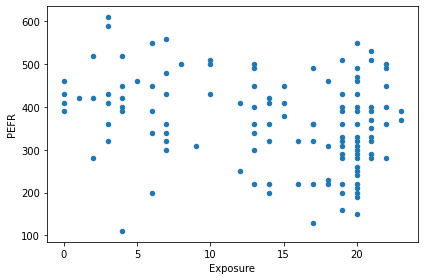

In [73]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

'scikit-learn' 내부에 있는 linear regression 함수를 사용합니다.

In [74]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome]) ## linear_regression 함수는 독립변수 인자로 dataframe을 받는다.

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


predict 함수를 이용해서 예측을 해보도록 하겠습니다. 노란색 점선은 residual을 의미합니다.

In [75]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

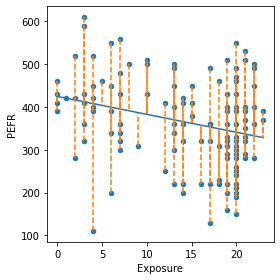

In [76]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

## Assessing the model

In [77]:
fitted = model.predict(lung[predictors])
RMSE = np.sqrt(mean_squared_error(lung[outcome], fitted))
r2 = r2_score(lung[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 101
r2: 0.0767


## 실습 - 다중회귀

# Multiple linear regression

In [78]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


###### 독립변수 : ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade'] 
###### 종속변수 : ['AdjSalePrice']

###### multiple linear regression model에 fitting 해보자. 
두가지 방법 : sklearn.linear_model의 LinearRegression() , statsmodels.api의 OLS().fit()

###### 이후 회귀계수를 구하고 적합이 잘 되었는지 $R^2$ 및 adjusted $R^2$를 구해서 확인해보자

In [80]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -528724.348
Coefficients:
 SqFtTotLiving: 212.7079279709183
 SqFtLot: -0.014301274559304744
 Bathrooms: -18233.211748820657
 Bedrooms: -46574.192686578
 BldgGrade: 108780.11134296592


In [81]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
adj_r2 = 1 - (1-r2)* ( ( house.shape[0] - 1  )  / ( house.shape[0] - len(predictors) -1 ) )
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')
print(f'adjusted_r2 :{adj_r2: .4f}')

RMSE: 259326
r2: 0.5348
adjusted_r2 : 0.5348


In [82]:
result = sm.OLS(house[outcome], house[predictors].assign(const = 1)).fit() ## 인자 순서가 LinearRegrssion 과 다르다.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     6222.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:22:57   Log-Likelihood:            -3.7576e+05
No. Observations:               27063   AIC:                         7.515e+05
Df Residuals:                   27057   BIC:                         7.516e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   212.7079      3.401     62.552      0.000     206.043     219.373
SqFtLot          -0.0143      0.058     -0.248      0.804      -0.127       0.099
Bathrooms     -1.823e+04   3224.583     -5.654      0.000   -2.46e+04   -1.19e+04
Bedrooms      -4.657e+04   2328.769    -19.999      0.000   -5.11e+04    -4.2e+04
BldgGrade      1.088e+05   2164.082     50.266      0.000    1.05e+05    1.13e+05
const         -5.287e+05   1.44e+04    -36.629      0.000   -5.57e+05      -5e+05
==============================================================================
Omnibus:                    34061.352   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19936035.252
Skew:                           6.420   Prob(JB):                         0.00
Kurtosis:                     135.344   Cond. No.                     2.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Dummy variables

In [83]:
house[predictors].head(10)

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,2400,9373,3.00,6,7
2,3764,20156,3.75,4,10
3,2060,26036,1.75,4,8
4,3200,8618,3.75,5,7
5,1720,8620,1.75,4,7
6,930,1012,1.50,2,8
7,1750,34465,1.50,3,8
8,1860,14659,1.75,4,7
9,990,5324,1.00,2,6
10,1980,10585,2.00,4,6


In [84]:
house_full = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     6222.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:25:54   Log-Likelihood:            -3.7576e+05
No. Observations:               27063   AIC:                         7.515e+05
Df Residuals:                   27057   BIC:                         7.516e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   212.7079      3.401     62.552

In [85]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

X.head(10)

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,2,0,1991,0,0,0,0
2,3764,20156,3.75,4,10,1,1452,2005,0,1,1,0
3,2060,26036,1.75,4,8,1,900,1947,0,0,1,0
4,3200,8618,3.75,5,7,1,1640,1966,0,0,1,0
5,1720,8620,1.75,4,7,1,0,1948,0,0,1,0
6,930,1012,1.50,2,8,1,0,2008,0,1,0,1
7,1750,34465,1.50,3,8,1,0,1961,0,0,1,0
8,1860,14659,1.75,4,7,1,620,1963,0,0,1,0
9,990,5324,1.00,2,6,1,0,1930,0,0,1,0
10,1980,10585,2.00,4,6,2,0,1924,0,0,0,0


In [ ]:
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     3248.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:10:05   Log-Likelihood:            -3.7405e+05
No. Observations:               27063   AIC:                         7.481e+05
Df Residuals:                   27050   BIC:                         7.482e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

# Factor variables in regression
## Dummy Variables Representation

In [86]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [87]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [88]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [89]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -440890.853
Coefficients:
 SqFtTotLiving: 207.23954229359651
 SqFtLot: -0.023138958459959724
 Bathrooms: -14996.6743669593
 Bedrooms: -49570.07618833293
 BldgGrade: 112183.58059922789
 PropertyType_Single Family: -98192.29974717954
 PropertyType_Townhouse: -118938.43483445117


## stepwise selection

In [92]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]


y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=772245.03, constant
Step: score=754910.45, add SqFtTotLiving
Step: score=752023.16, add BldgGrade
Step: score=749035.73, add YrBuilt
Step: score=748559.37, add Bedrooms
Step: score=748275.34, add Bathrooms
Step: score=748116.31, add PropertyType_Townhouse
Step: score=748113.49, add SqFtFinBasement
Step: score=748113.25, add PropertyType_Single Family
Step: score=748113.25, unchanged None

Intercept: 6227632.223
Coefficients:
 SqFtTotLiving: 186.50122142198967
 BldgGrade: 139179.2256957234
 YrBuilt: -3592.4675618887068
 Bedrooms: -49807.178485644596
 Bathrooms: 44721.72109363887
 PropertyType_Townhouse: 92216.25324971533
 SqFtFinBasement: 9.039911052794196
 PropertyType_Single Family: 23328.685220410487


# Interpreting the Regression Equation

## Correlated variables 

- including different variables that have a similar predictive relationship

아래 두 셀에서 'Bedrooms' 변수에 대한 계수값이 서로 달라졌음에 주목합니다.

In [93]:
# stepwise selection으로 구한 best_model

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6227632.223
Coefficients:
 SqFtTotLiving: 186.50122142198967
 BldgGrade: 139179.2256957234
 YrBuilt: -3592.4675618887068
 Bedrooms: -49807.178485644596
 Bathrooms: 44721.72109363887
 PropertyType_Townhouse: 92216.25324971533
 SqFtFinBasement: 9.039911052794196
 PropertyType_Single Family: 23328.685220410487


빠진 변수 : SqFtTotLiving, Bathrooms, SqFtFinBasement

In [ ]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4834679.732
Coefficients:
 Bedrooms: 27656.816554225657
 BldgGrade: 245709.38992930102
 YrBuilt: -3160.629201101343
 PropertyType_Single Family: -17603.91511703555
 PropertyType_Townhouse: -47477.23666411602


왜 이런 현상이 발생할까요? 

우선 기존 변수들간의 correlation을 heatmap으로 나타내보겠습니다

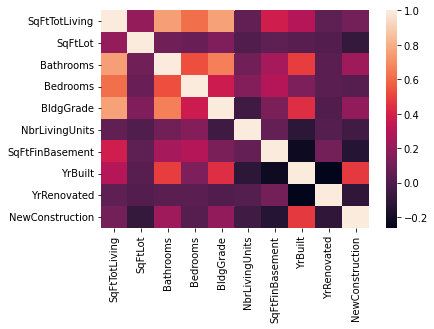

In [94]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

sns.heatmap(house[predictors].corr())

다중회귀에서 회귀계수 $\beta_j$ 는 다른 모든 입력변수가 동일할 때 $x_j$가 한단위 증가할 때 Y가 증가하는 평균 양이다

## Confounding variables

- important variables that is not included in the regression equation

**집값을 예측하는 데 중요한 변수는 집의 위치이므로 이를 고려한 회귀직선을 만들자**

In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')


In [ ]:
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

0    17
1    16
2    17
3    16
4    17
Name: ZipGroup, dtype: int64


In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']  # zipGroup 변수가 없을때는 Bedroom, Bathrooms, SqFtLot 변수가 negative => un-intuitive!
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -440890.853
Coefficients:
 SqFtTotLiving: 207.23954229359651
 SqFtLot: -0.023138958459959724
 Bathrooms: -14996.6743669593
 Bedrooms: -49570.07618833293
 BldgGrade: 112183.58059922789
 PropertyType_Single Family: -98192.29974717954
 PropertyType_Townhouse: -118938.43483445117


In [ ]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup'] # zipGroup 변수를 추가했더니 Bethroom, SqFtLot 변수가 negative => positive
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580126
 SqFtLot: 0.4549871385466056
 Bathrooms: 5928.425640001846
 Bedrooms: -41682.87184074475
 BldgGrade: 98541.18352725967
 PropertyType_Single Family: 19323.625287919363
 PropertyType_Townhouse: -78198.72092762393
 ZipGroup_1: 53317.1733065983
 ZipGroup_2: 116251.58883563569
 ZipGroup_3: 178360.53178793378
 ZipGroup_4: 338408.6018565204


# Testing the Assumptions: Regression Diagnostics
## Outliers

In [95]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          1.69e-103
Time:                        03:37:29   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

OLS regression 결과를 인자로 하는 `OLSInfluence` class를 통해 실행시켜 studentized residuals를 얻을 수 있습니다.

In [96]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min()) # sresiduals의 minimum 

24333 -4.32673180407856


outlier 에 해당하는 datapoint 값을 확인해봅니다.

In [99]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


## Influential values

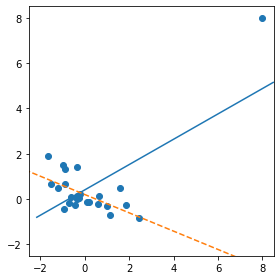

In [100]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

In [101]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedasticity, Non-Normality

`regplot`을 사용해서 residual plot을 쉽게 그릴 수 있습니다.

< heteroskedasticity > - 이분산성

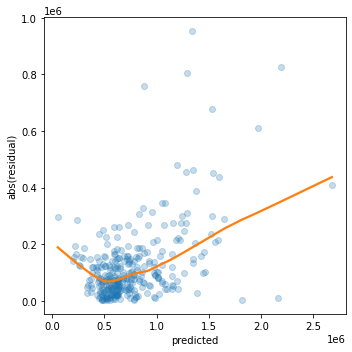

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

< non-normality >

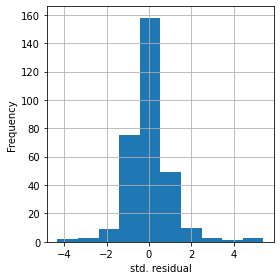

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

## <참고> Partial Residual Plots and Nonlinearity

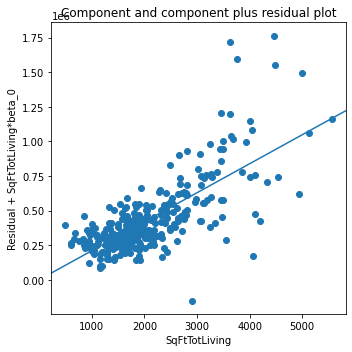

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

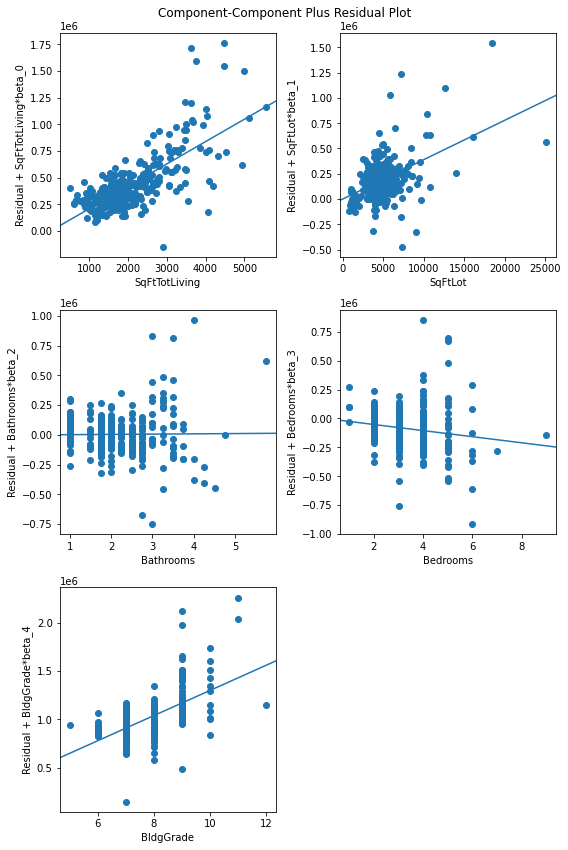

In [ ]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## <참고> Polynomial and Spline Regression

In [ ]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          9.95e-106
Time:                        02:43:41   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

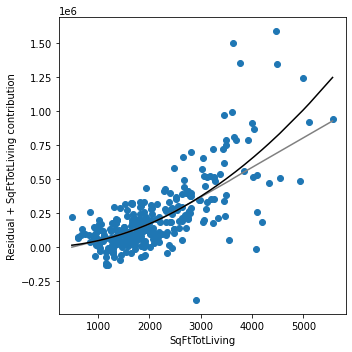

0.03879128168231147


In [102]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [103]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          7.10e-104
Time:                        03:43:25   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

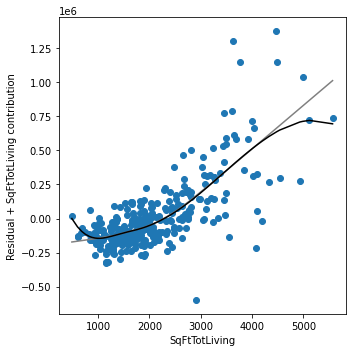

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()